Data Preprocessing
========================

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import argparse
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
df = pd.read_csv("EBITDA_preprocess.csv")
df.head()

,tic,datafqtr,cshoq,cshtrq,capxy,niq,xoprq,teqq,atq,epsfiq,...,EBITDA_growth,EBITDA_margin,conm,EBITDA,SALE PRICE,Real GDP SA(billion),M2 SA(billion),M2-M1 Growth Gap(%),M2V,Prime Rate(%)
0,NLP,2010Q1,10.666,263614.0,0.0,-2.568,11.450,63.433,309.571,-0.23,...,0.0,NaN,NTS REALTY HOLDINGS LP,-0.002,596771.895388,16582.710,8509.766667,NaN,1.735,3.25
1,NLP,2010Q2,10.666,235341.0,0.0,-2.608,12.143,59.999,304.493,-0.23,...,0.0,NaN,NTS REALTY HOLDINGS LP,-0.001,623600.673062,16743.162,8597.600000,-0.035405,1.742,3.25
2,NLP,2010Q3,10.666,159175.0,0.0,-3.197,11.950,55.925,299.536,-0.28,...,0.0,NaN,NTS REALTY HOLDINGS LP,-0.006,645188.876686,16872.266,8682.300000,-0.925087,1.744,3.25
3,NLP,2010Q4,10.666,163338.0,0.0,-3.023,11.716,52.167,328.566,-0.26,...,0.0,NaN,NTS REALTY HOLDINGS LP,-0.003,956586.999871,16960.864,8793.633333,-2.661274,1.741,3.25
4,NLP,2011Q1,10.666,177414.0,0.0,-3.392,12.967,48.098,325.605,-0.30,...,0.0,NaN,NTS REALTY HOLDINGS LP,-0.006,607552.961452,16920.632,8907.066667,-1.784149,1.724,3.25


# Rename columns for better readability

In [3]:
# Rename DataFrame columns to follow camelCase convention and match original definitions from the images

# Basic company identifiers
df = df.rename(columns={
    'tic': 'ticker',  # Stock ticker symbol
    'datafqtr': 'fiscalQuarter',  # Fiscal quarter date
    'conm': 'companyName'  # Company name
})

# Target variables (what we're trying to predict)
df = df.rename(columns={
    'EBITDA': 'EBITDA',  # Earnings Before Interest, Taxes, Depreciation and Amortization (target2)
    'SALE PRICE': 'salePrice'  # Mean sale price per quarter (from additional variables)
})

# Basic financial variables (raw data from financial statements)
df = df.rename(columns={
    'cshoq': 'commonSharesOutstanding_',  # Number of common shares outstanding
    'cshtrq': 'commonSharesTraded_',  # Common shares traded
    'capxy': 'capitalExpenditure_',  # Funds used to acquire/upgrade physical assets
    'niq': 'netIncome_',  # Net income (profit after all expenses)
    'xoprq': 'operatingIncome_',  # Operating income after depreciation
    'teqq': 'shareholdersEquity_',  # Total shareholders' equity
    'atq': 'totalAssets_',  # Total assets on balance sheet
    'epsfiq': 'EPS_',  # Earnings per share (profit per outstanding share)
    'cogsq': 'costOfGoodsSold_'  # Cost of goods sold
})

# Engineered financial features (calculated metrics)
df = df.rename(columns={
    'Debt_to_TA': 'debtToTotalAssets',  # Total debt divided by total assets
    'NI_to_Asset': 'niToAsset',  # Net income divided by average assets
    'ROA': 'ROA',  # Return on assets (net income/total assets)
    'ROE': 'ROE',  # Return on equity (net income/shareholders' equity)
    'Revenue_growth': 'revenueGrowth',  # Quarter-over-quarter revenue growth
    'NI_growth': 'netIncomeGrowth',  # Quarter-over-quarter net income growth
    'Current_ratio': 'currentRatio',  # Current ratio (current assets/current liabilities)
    'Quick_ratio': 'quickRatio',  # (Current assets - inventories)/current liabilities
    'RSI': 'rsi',  # Relative Strength Index (momentum indicator)
    'MVA': 'mva',  # Market Value Added (not explicitly defined in images)
    'CFROI': 'cfroi',  # Cash flow return on investment (OCF/Capital Employed)
    'EBITDA_growth': 'ebitdaGrowth',  # EBITDA year-over-year growth
    'EBITDA_margin': 'ebitdaMargin'  # EBITDA as a percentage of revenue
})

# Macroeconomic variables (external factors)
df = df.rename(columns={
    'Real GDP SA(billion)': 'realGDPSA',  # Seasonally adjusted real GDP
    'M2 SA(billion)': 'm2SA',  # Seasonally adjusted M2 money supply
    'M2-M1 SA(billion)': 'm2MinusM1SA',  # Difference between M2 and M1 money supply
    'M2-M1 Growth Gap(%)': 'm2m1GrowthGap',  # Gap between M2 and M1 growth rates
    'M2V': 'm2Velocity',  # Velocity of M2 money supply
    'Prime Rate(%)': 'primeRate'  # Benchmark interest rate
})

# Note: Some variables from the images weren't found in the original column list:
# - Revenue (revtq) - appears to be missing from original columns
# - Rooms Expenses (gmrmexpoq)
# - Room Revenue (gmrnewq)
# - Various homebuilding inventory metrics
# These would need to be added if present in the dataset

print(df.columns.tolist())

['ticker', 'fiscalQuarter', 'commonSharesOutstanding_', 'commonSharesTraded_', 'capitalExpenditure_', 'netIncome_', 'operatingIncome_', 'shareholdersEquity_', 'totalAssets_', 'EPS_', 'costOfGoodsSold_', 'debtToTotalAssets', 'niToAsset', 'ROA', 'revenueGrowth', 'netIncomeGrowth', 'currentRatio', 'mva', 'cfroi', 'ebitdaGrowth', 'ebitdaMargin', 'companyName', 'EBITDA', 'salePrice', 'realGDPSA', 'm2SA', 'm2m1GrowthGap', 'm2Velocity', 'primeRate']


# Company selection

In [4]:
nyc_real_estate_tickers = [
    'NEN',  # New York Mortgage Trust, Inc.
    'LEJUY',  # Leju Holdings Limited
    'MRCBF',   # Cushman & Wakefield plc
    'ACAN',  # Douglas Elliman Inc.
    'MDPCF',   # Jones Lang LaSalle Inc.
    'HMT.',  # Anywhere Real Estate Inc.
    'GYRO',  # RE/MAX Holdings, Inc.
    'PRLEQ',  # eXp World Holdings, Inc.
    'MYCB',  # Opendoor Technologies Inc.
    'TNL',  # Offerpad Solutions Inc.
    'MODVF',  # KE Holdings Inc. (Limited NYC presence)
    'ARL',  # Redfin Corporation
    # 'CIGI',  # Colliers International Group Inc.
    # 'FSV',   # FirstService Corporation
    # 'TCN',   # Tricon Residential Inc.
]
# Check if these tickers are in the DataFrame, which are not in the original list
for ticker in nyc_real_estate_tickers:
    if ticker not in df['ticker'].values:
        print(f"{ticker} is not in the DataFrame")
    else:
        print(f"{ticker} is in the DataFrame")

NEN is in the DataFrame
LEJUY is in the DataFrame
MRCBF is in the DataFrame
ACAN is in the DataFrame
MDPCF is in the DataFrame
HMT. is in the DataFrame
GYRO is in the DataFrame
PRLEQ is in the DataFrame
MYCB is in the DataFrame
TNL is in the DataFrame
MODVF is in the DataFrame
ARL is in the DataFrame


In [5]:
selected_companies = df[df['ticker'].isin(nyc_real_estate_tickers)]

# Process before the data preprocessing phase
## Remove unnecessary columns

In [6]:
# Check for duplicate rows in the selected companies DataFrame
duplicate_rows = selected_companies[selected_companies.duplicated()]
if not duplicate_rows.empty:
    print("Duplicate rows in selected companies DataFrame:")
    print(duplicate_rows)
else:
    print("No duplicate rows in selected companies DataFrame")

No duplicate rows in selected companies DataFrame


## Check missing values

In [7]:
# Check numeric columns from the selected companies DataFrame
numeric_columns = selected_companies.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns in selected companies DataFrame:")
print(numeric_columns)
# Check for missing values in the numeric columns
missing_numeric_values = selected_companies[numeric_columns].isnull().sum()
missing_numeric_values = missing_numeric_values[missing_numeric_values > 0]
if not missing_numeric_values.empty:
    print("Missing values in numeric columns of selected companies DataFrame:")
    print(missing_numeric_values)


Numeric columns in selected companies DataFrame:
['commonSharesOutstanding_', 'commonSharesTraded_', 'capitalExpenditure_', 'netIncome_', 'operatingIncome_', 'shareholdersEquity_', 'totalAssets_', 'EPS_', 'costOfGoodsSold_', 'debtToTotalAssets', 'niToAsset', 'ROA', 'revenueGrowth', 'netIncomeGrowth', 'currentRatio', 'mva', 'cfroi', 'ebitdaGrowth', 'ebitdaMargin', 'EBITDA', 'salePrice', 'realGDPSA', 'm2SA', 'm2m1GrowthGap', 'm2Velocity', 'primeRate']
Missing values in numeric columns of selected companies DataFrame:
commonSharesTraded_     14
debtToTotalAssets        5
niToAsset                5
ROA                     14
currentRatio           295
mva                     54
cfroi                  304
ebitdaMargin           167
m2m1GrowthGap            3
dtype: int64


# Preprocessing Steps

## Numerical features

### Process Outliers

In [10]:
from scipy.stats.mstats import winsorize

def handle_outliers(df, columns):
    """
    Handle outliers using the IQR method, clipping data to a reasonable range.
    """
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)
    return df

    def handle_outliers_winsorize(df, columns, limits=(0.05, 0.05)):
        """
        Handle outliers using winsorization, which limits extreme values to a specified percentile.
        """
        for col in columns:
            df[col] = winsorize(df[col], limits=limits)
        return df

### Normalize numerical features

In [11]:
from sklearn.preprocessing import StandardScaler, RobustScaler

def scale_features(df, columns):
    """
    Standardize numerical features.
    """
    scaler = RobustScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

In [12]:
# Utility function 

def add_time_series_features(df):
    """
    Add time series features, such as lag values and time-related features.
    """
    df = df.sort_values(['ticker', 'fiscalQuarter'])
    df['EBITDA_lag1'] = df.groupby('ticker')['EBITDA'].shift(1)
    df['year'] = df['fiscalQuarter'].str[:4].astype(int)
    df['quarter'] = df['fiscalQuarter'].str[-1].astype(int)
    return df


def remove_multicollinearity(df, columns_to_drop):
    """
    Remove columns with high multicollinearity. Supports dropping multiple columns.
    """
    if isinstance(columns_to_drop, list):
        df = df.drop(columns=columns_to_drop)
    else:
        raise ValueError("columns_to_drop should be a list of column names.")
    return df

### Process missing (Null) values
<!-- 
EPS_                         9
commonSharesOutstanding_    24
commonSharesTraded_         54
quickRatio                  10
rsi                         64
mva                         70
cfroi                       10 -->

In [13]:
# Check for missing values in the DataFrame
# missing_values = selected_companies.isnull().sum()
# # Drop columns with missing values
# selected_companies = selected_companies.drop(columns=missing_values[missing_values > 0].index.tolist())
def process_missing_value(df, threshold=0.3):
    """
    Handle missing values: drop columns with missing ratio above the threshold 
    and fill remaining missing values with the median.
    """
    missing_ratio = df.isnull().sum() / len(df)
    df = df.drop(columns=missing_ratio[missing_ratio > threshold].index)
    for col in df.select_dtypes(include=['float64', 'int64']):
        df[col].fillna(df[col].median(), inplace=True)
    return df

In [14]:
import numpy as np
import pandas as pd

def apply_log_transform(df, columns_to_transform, add_small_constant=True):
    """
    对DataFrame的指定列进行对数变换（log(1 + x)），避免零或负值问题
    
    参数:
    - df: 输入的DataFrame
    - columns_to_transform: 需要变换的列名列表
    - add_small_constant: 是否对数据加1（避免log(0)）
    
    返回:
    - 变换后的DataFrame
    """
    df_transformed = df.copy()
    
    for col in columns_to_transform:
        if col not in df.columns:
            print(f"警告: 列 '{col}' 不存在，跳过")
            continue
            
        if add_small_constant:
            # 使用 log(1 + x) 避免零或负值问题
            df_transformed[col] = np.log1p(df_transformed[col])
        else:
            # 仅对正值数据取对数
            if (df_transformed[col] <= 0).any():
                print(f"警告: 列 '{col}' 包含零或负值，建议使用 log(1 + x) 或检查数据")
            df_transformed[col] = np.log(df_transformed[col])
    
    return df_transformed

In [15]:
selected_companies.head(3).to_csv("selected_companies.csv", index=False)

In [16]:
def preprocess_numeric_data(df):
    """
    Main function: call sub-functions to preprocess numerical data.
    """
    # 1. Handle missing values
    df = process_missing_value(df)

    # 2. Handle outliers
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    ratio_cols = ['debtToTotalAssets', 'niToAsset', 'ROA', 'EPS_', 'revenueGrowth', 'netIncomeGrowth', 'currentRatio', 'ebitdaGrowth', 'ebitdaMargin', 'm2m1GrowthGap', 'm2Velocity', 'primeRate',
                  ]  # Exclude ratio columns
    cols_to_process = list(set(numeric_cols) - set(ratio_cols))
    df = handle_outliers(df, cols_to_process)


# capitalExpenditure_ totalAssets_ 
# commonSharesOutstanding_
    log_transform_cols = [
        "commonSharesTraded_",
        "salePrice",
        "totalAssets_",
        "capitalExpenditure_",
        "m2SA"
    ]
    df = apply_log_transform(df, log_transform_cols)

    #  Add time series features
    df = add_time_series_features(df)

    # 5. Scale features
    scale_columns = [
        "commonSharesOutstanding_",
        "netIncome_",
        "operatingIncome_",
        "shareholdersEquity_",
        "costOfGoodsSold_",
        "realGDPSA"
    ]

    # ['debtToTotalAssets', 'niToAsset', 'ROA', 'currentRatio',
    #  'revenueGrowth', 'netIncomeGrowth', 'ebitdaGrowth',
    #  'ebitdaMargin', 'realGDPSA', 'm2SA']

    df = scale_features(df, scale_columns)

    return df


# Execute preprocessing
processed_df = preprocess_numeric_data(selected_companies.copy())

# Preprocessing Performance Comparison

## Verify outliers detection

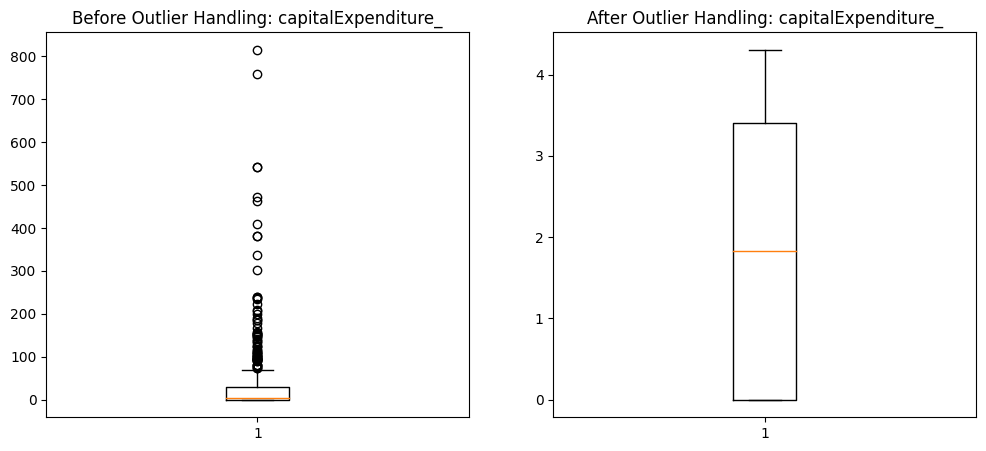

In [17]:
import matplotlib.pyplot as plt

def compare_outliers(df_before, df_after, column):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.boxplot(df_before[column].dropna())
    plt.title(f"Before Outlier Handling: {column}")
    
    plt.subplot(1, 2, 2)
    plt.boxplot(df_after[column].dropna())
    plt.title(f"After Outlier Handling: {column}")
    
    plt.show()

compare_outliers(selected_companies, processed_df, 'capitalExpenditure_')


## Verify scaling performance

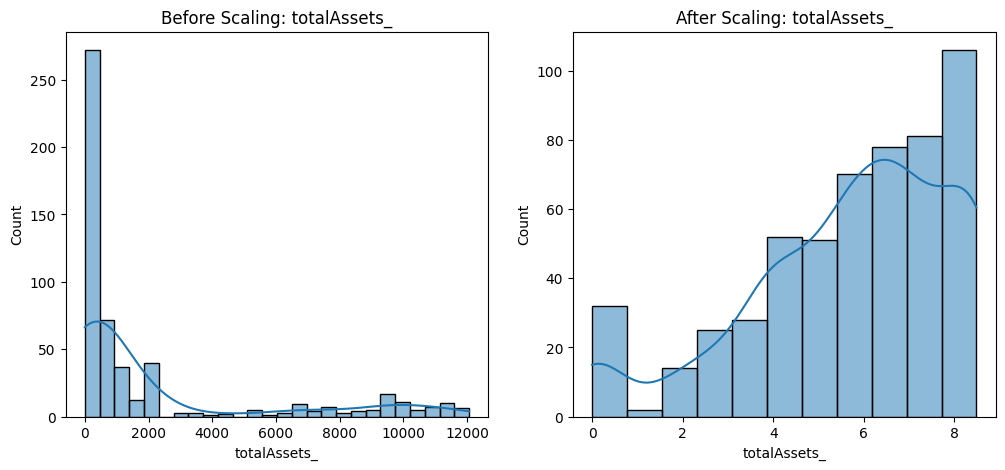

In [18]:
import seaborn as sns
def check_scaling(df_before, df_after, column):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df_before[column], kde=True)
    plt.title(f"Before Scaling: {column}")
    
    plt.subplot(1, 2, 2)
    sns.histplot(df_after[column], kde=True)
    plt.title(f"After Scaling: {column}")
    
    plt.show()

# 示例：检查totalAssets_的缩放效果
check_scaling(selected_companies, processed_df, 'totalAssets_')

## Check numerical features distribution after preprocessing

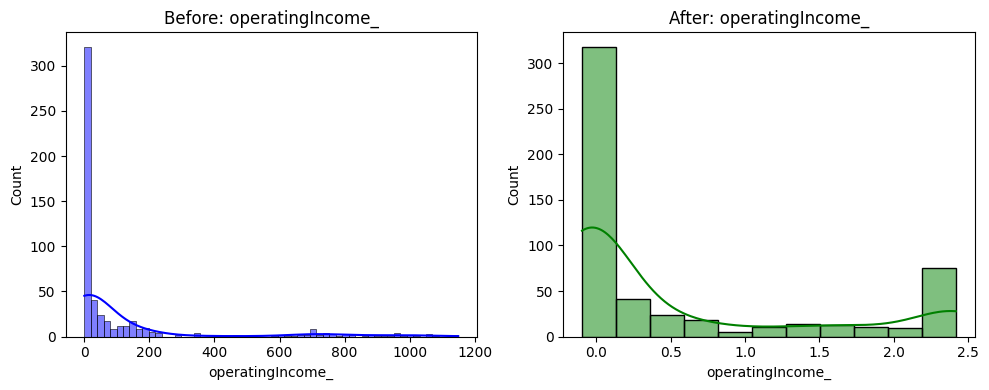

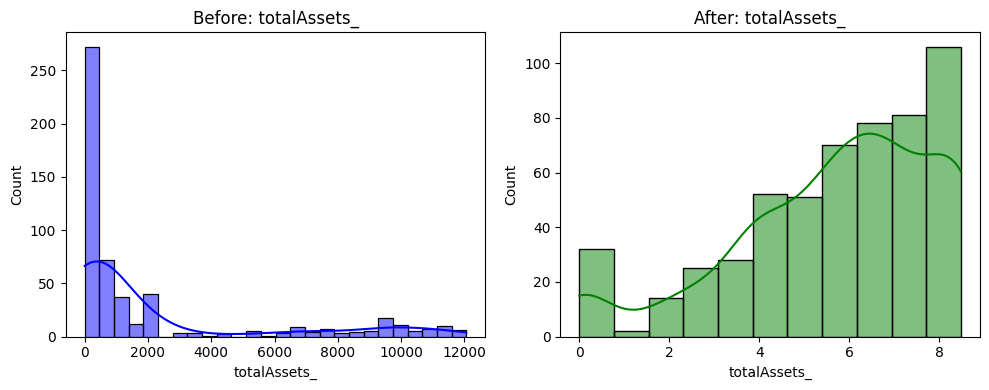

In [19]:
def plot_distribution_comparison(df_before, df_after, columns, log_scale=False):
    for col in columns:
        plt.figure(figsize=(10, 4))
        
        # Distribution before processing
        plt.subplot(1, 2, 1)
        sns.histplot(df_before[col], kde=True, color='blue')
        if log_scale:
            plt.yscale('log')
        plt.title(f"Before: {col}")
        
        # Distribution after processing
        plt.subplot(1, 2, 2)
        sns.histplot(df_after[col], kde=True, color='green')
        if log_scale:
            plt.yscale('log')
        plt.title(f"After: {col}")
        
        plt.tight_layout()
        plt.show()

# Example: Check key numerical columns
numeric_cols = ['operatingIncome_', 'totalAssets_']
plot_distribution_comparison(selected_companies, processed_df, numeric_cols)

## Check correlation matrix

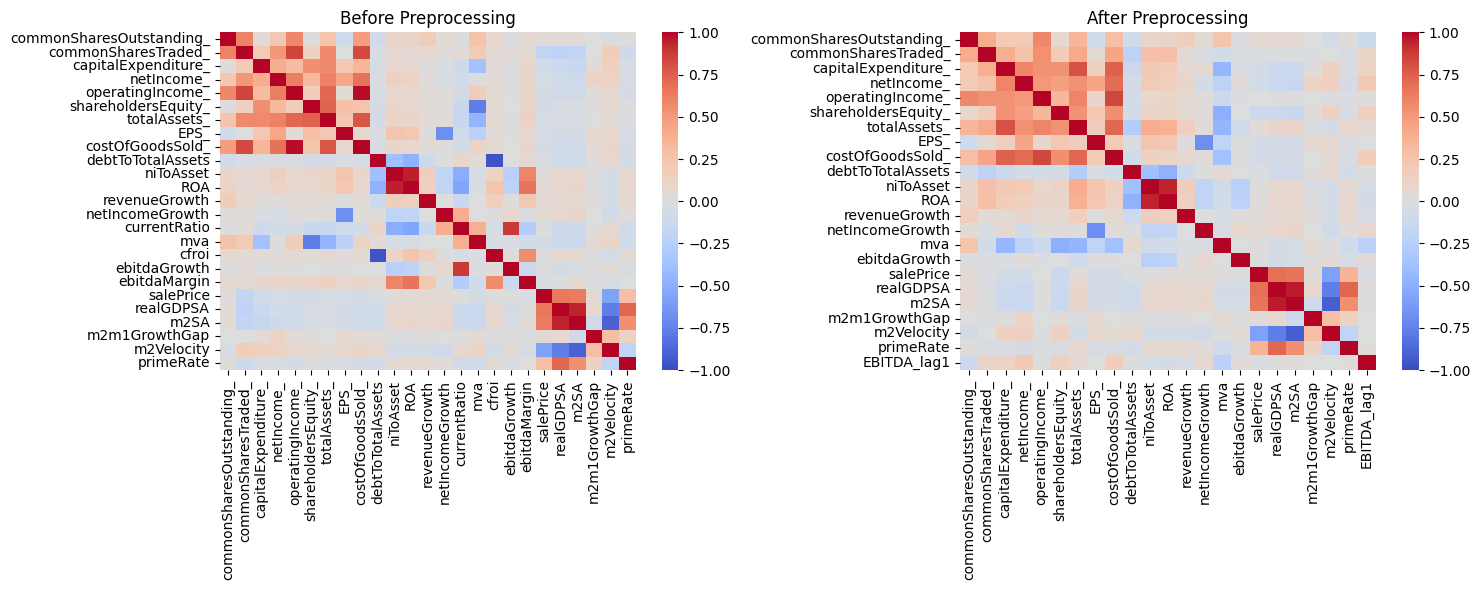

In [20]:
def compare_correlation(df_before, df_after):
    plt.figure(figsize=(15, 6))
    
    # Drop the 'EBITDA' column before calculating correlations
    df_before_corr = df_before.drop(columns=['EBITDA']).select_dtypes(include=['float64']).corr()
    df_after_corr = df_after.drop(columns=['EBITDA']).select_dtypes(include=['float64']).corr()
    
    plt.subplot(1, 2, 1)
    sns.heatmap(df_before_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Before Preprocessing")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(df_after_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("After Preprocessing")
    
    plt.tight_layout()
    plt.show()

compare_correlation(selected_companies, processed_df)

# Save files

In [21]:
processed_df.to_csv("EBITDA_new.csv", index=False)
print("New CSV file created: EBITDA_new.csv")

New CSV file created: EBITDA_new.csv


In [23]:
# 打印每一列的数据统计
print(df.describe(include='all'))

       ticker fiscalQuarter  commonSharesOutstanding_  commonSharesTraded_  \
count    2232          2232               2169.000000         2.079000e+03   
unique    120            61                       NaN                  NaN   
top       ARL        2018Q4                       NaN                  NaN   
freq       56            44                       NaN                  NaN   
mean      NaN           NaN                 70.714525         2.183688e+07   
std       NaN           NaN                147.822186         8.484649e+07   
min       NaN           NaN                  0.000000         0.000000e+00   
25%       NaN           NaN                 10.381000         7.774950e+04   
50%       NaN           NaN                 26.496000         7.414550e+05   
75%       NaN           NaN                 66.709000         9.180623e+06   
max       NaN           NaN               2110.021000         1.134313e+09   

        capitalExpenditure_   netIncome_  operatingIncome_  \
c

In [24]:
# 打印 EBITDA 列的统计信息
print(df['EBITDA'].describe())

count    2232.000000
mean       29.468594
std       108.096548
min      -541.604000
25%        -0.014000
50%         1.527000
75%        21.022750
max      1293.000000
Name: EBITDA, dtype: float64


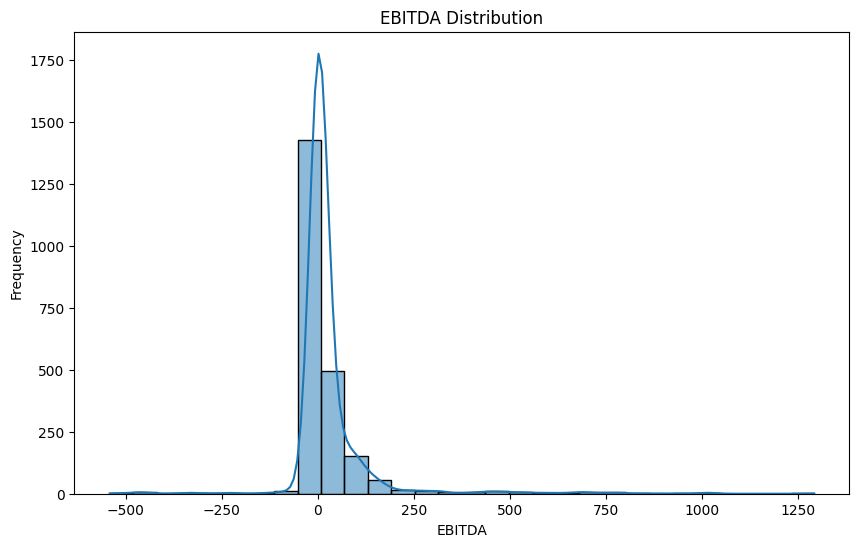

In [25]:
# 打印EBITDA的数值分布
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['EBITDA'], bins=30, kde=True)
plt.title('EBITDA Distribution')
plt.xlabel('EBITDA')
plt.ylabel('Frequency')
plt.show()

done
<!-- 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 选择特征和目标变量
features = ['capitalExpenditure_', 'netIncome_', 'operatingIncome_', 'shareholdersEquity_', 
            'totalAssets_', 'EPS_', 'debtToTotalAssets', 'niToAsset', 'ROA', 'revenueGrowth', 
            'quickRatio', 'rsi', 'mva', 'cfroi', 'salePrice', 'realGDPSA', 'm2SA', 
            'm2MinusM1SA', 'm2Velocity', 'primeRate', 'EBITDA_lag1']
target = 'EBITDA'

# 去除缺失值
processed_df = processed_df.dropna(subset=features + [target])

# 数据归一化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(processed_df[features + [target]])

# 构造时间序列数据
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

seq_length = 10  # 时间步长
X, y = create_sequences(scaled_data, seq_length)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 构建LSTM模型
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 预测
y_pred = model.predict(X_test)

# 反归一化预测值和真实值
y_test_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], len(features))), y_test.reshape(-1, 1))))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], len(features))), y_pred)))[:, -1]

# 评估模型性能
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}") -->